# Generate 5D DTLZ2 Depth Contours and Tradeoff measure
## Code to generate 5D DTLZ2 depth contour and tradeoff values for EMO-2021

This notebook generates different properties for the paletteviz plot of 5D DTLZ2 PF, for EMO-2021 paper.

In [1]:
%matplotlib notebook
%reload_ext autoreload
%autoreload 2

import sys
import os

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams.update({'figure.max_open_warning': 0})
np.random.seed(123456)

### Function to generate $\mathbf{R}$

In [2]:
import numpy as np
sys.path.append('../../')
from vis.generators import dtlz2
from vis.generators import c2dtlz2
from vis.generators import c0dtlz2

def generate_r(F, frontname, verbose=False):
    n = {'dtlz2': F.shape[0], 'c2dtlz2': 210000, 'c0dtlz2': 5000}
    
    LB, UB = np.mean(np.min(F, axis=0)), np.mean(np.max(F, axis=0))
    r = UB - LB
    if frontname == 'dtlz2':
        R, _ = dtlz2.surface(r=r, n=n[frontname], m=F.shape[1], mode='lhcl2')
    elif frontname == 'c2dtlz2':
        R, _, _ = c2dtlz2.surface(r=r, n=n[frontname], m=F.shape[1], mode='lhcl2')
    elif frontname == 'c0dtlz2':
        R, _, _ = c0dtlz2.surface(r=r, n=n[frontname], m=F.shape[1])
    else:
        raise ValueError("PF generation function for {:s} is not supported.".format(frontname))

    # check
    if verbose:
        print("F.shape =", F.shape)
        print("R.shape =", R.shape)
    
    return R

### An L2-norm based $\mathcal{d}_{\mathbf{F}}(\cdot)$ approximation function

In [3]:
import os
import numpy as np
sys.path.append('../../')
from vis.tda import simple_shape
from vis.utils import io

def approximate_depth_l2norm(F, frontname, save_ref_depth=False, verbose=False):
    # Generate a random data points that are on the same surface as F.
    # These points are R
    R = generate_r(F, frontname, verbose=verbose)
    
    # Now find depth contours from R
    if verbose:
        print("Computing depth contours of", pf)
    Dr = simple_shape.depth_contours(R, verbose=verbose)

    # Save in a temp file
    if save_ref_depth:
        drfname = frontname + "-r-depth-cont-cvhull.csv"
        drfpath = os.path.join("/tmp", drfname)
        io.savetxt(drfpath, Dr, fmt='{:d}', delimiter=',')
    
    # Find depth contour of F from that of R
    Dr_ = Dr[::-1]
    Id = np.arange(0,F.shape[0]).astype(int)
    Df = []
    while Id.shape[0] > 0:
        # for each layer l in d_R
        for l in Dr_:
            s = []
            # for each index i in l
            for i in l.astype(int):
                # find the point j in F that is closest to R[i]
                if Id.shape[0] > 0:
                    j = np.argmin(np.linalg.norm(F[Id]-R[i], axis=1))
                    s.append(Id[j])
                    Id = np.delete(Id, j)
                else:
                    break
            if len(s) > 0:
                Df.append(np.array(s).astype(int))
    Df = np.array(Df, dtype=object)
    Df = Df[::-1]
    
    # print and check counts
    if verbose:
        print("Df.shape[0] =", Df.shape[0])
        s = 0
        for i,l in enumerate(Df):
            print("Df[{:d}].shape[0] =".format(i), l.shape[0])
            s = s + l.shape[0]
        print("total =", s)

        print("Dr.shape[0] =", Dr.shape[0])
        s = 0
        for i,l in enumerate(Dr):
            print("Dr[{:d}].shape[0] =".format(i), l.shape[0])
            s = s + l.shape[0]
        print("total =", s)

    return R,Dr,Df

### Find depth-contours for the failed case

F.shape = (999, 5)
R.shape = (999, 5)
Computing depth contours of dtlz2-nbi
Projecting on a simplex and collapsing.
Computing depth contour 0 ...
Computing depth contour 1 ...
Computing depth contour 2 ...
Computing depth contour 3 ...
Computing depth contour 4 ...
Computing depth contour 5 ...
Computing depth contour 6 ...
Computing depth contour 7 ...
Df.shape[0] = 9
Df[0].shape[0] = 224
Df[1].shape[0] = 209
Df[2].shape[0] = 169
Df[3].shape[0] = 145
Df[4].shape[0] = 99
Df[5].shape[0] = 69
Df[6].shape[0] = 59
Df[7].shape[0] = 21
Df[8].shape[0] = 4
total = 999
Dr.shape[0] = 9
Dr[0].shape[0] = 224
Dr[1].shape[0] = 209
Dr[2].shape[0] = 169
Dr[3].shape[0] = 145
Dr[4].shape[0] = 99
Dr[5].shape[0] = 69
Dr[6].shape[0] = 59
Dr[7].shape[0] = 21
Dr[8].shape[0] = 4
total = 999


<IPython.core.display.Javascript object>


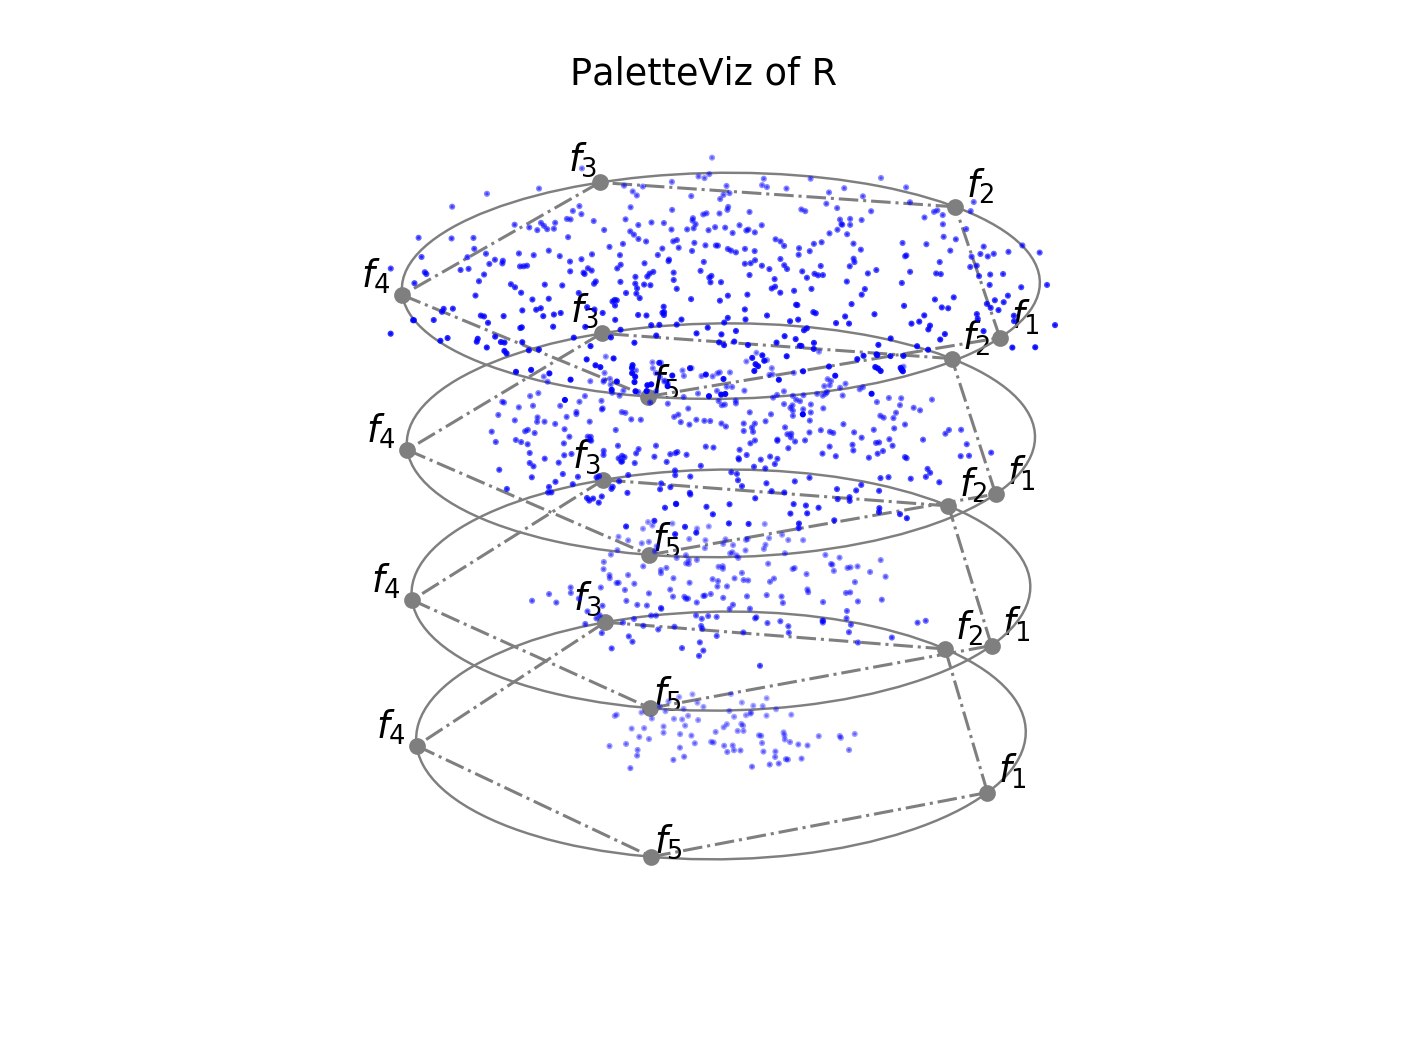

Plotting palette-star-viz.
Using depth contours ndarray.


<IPython.core.display.Javascript object>


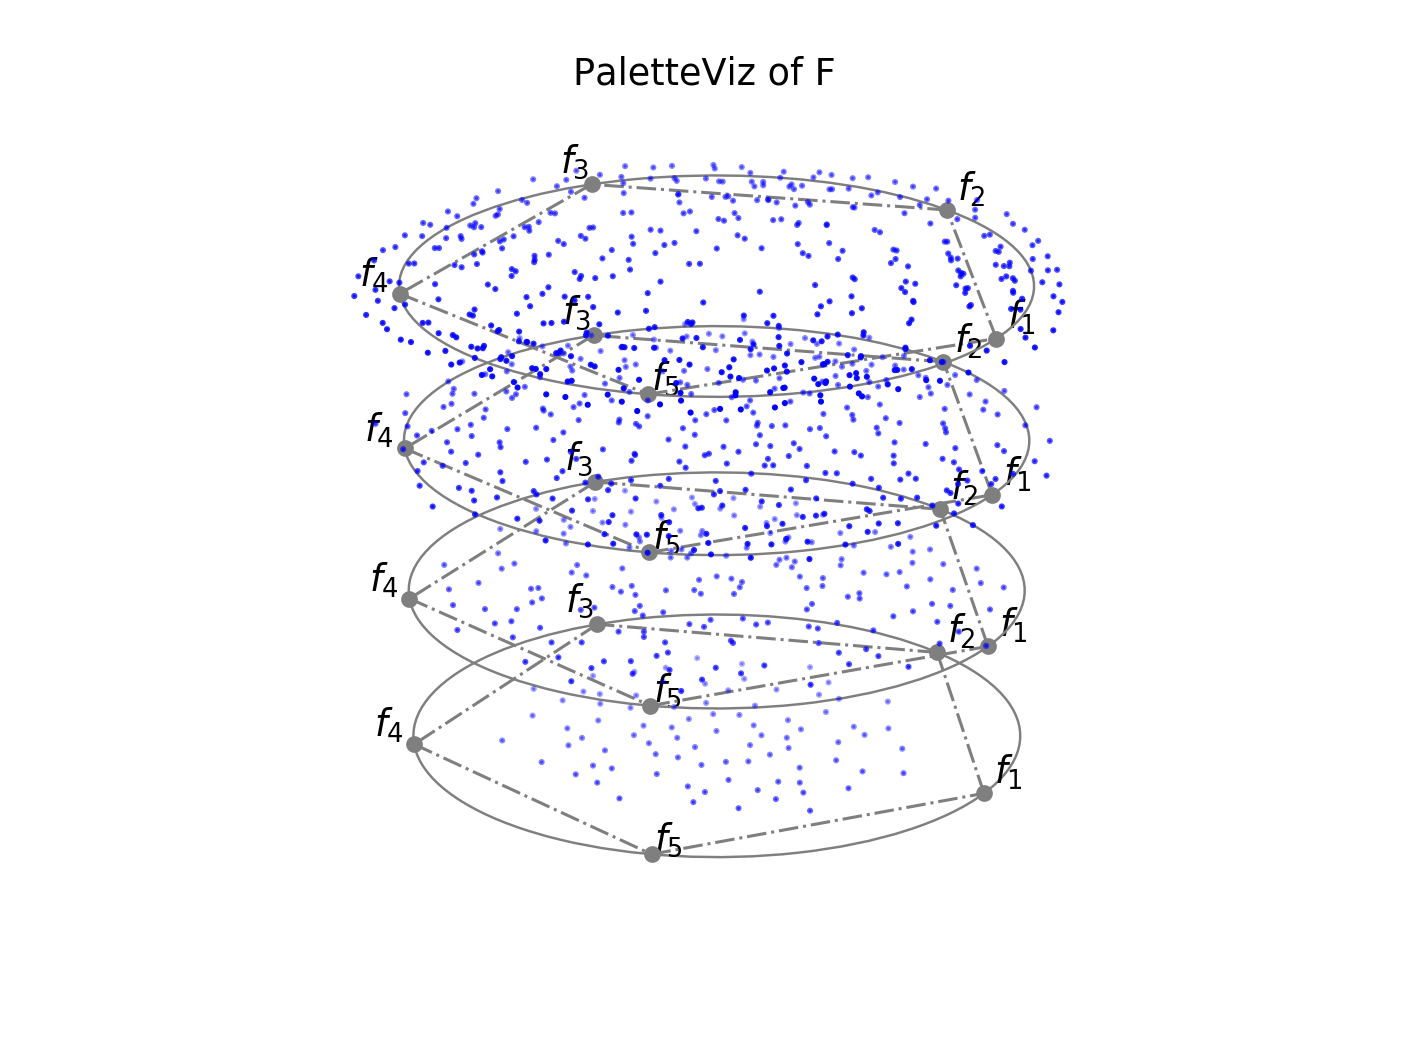

Plotting palette-star-viz.
Using depth contours ndarray.


In [4]:
sys.path.append('../../')
from vis.utils import io
from vis.plotting import paletteviz


# Data where the depth contours were not 
# possible to compute, these are F's.
pf, dim = 'dtlz2-nbi', '5d'

fpath = "../../data/{0:s}/{1:s}/dataf.csv".format(pf, dim)
if os.path.exists(fpath):
    path, _ = os.path.split(fpath)
    dirs = path.split('/')
    frontname = dirs[-2].split('-')[0]

    F = np.loadtxt(fpath, delimiter=',')

    # Approximate depth contours of F from R
    R,Dr,Df = approximate_depth_l2norm(F, frontname, verbose=True, save_ref_depth=True)

    # plot and verify
    paletteviz.plot(R, ax=Axes3D(plt.figure()), depth_contours=Dr, mode='star', \
                    n_partitions=4, s=1, c='blue', verbose=True, title="PaletteViz of R")
    plt.show()

    # plot and verify
    paletteviz.plot(F, ax=Axes3D(plt.figure()), depth_contours=Df, mode='star', \
                    n_partitions=4, s=1, c='blue', verbose=True, title="PaletteViz of F")
    plt.show()

    # save the layers
    io.savetxt(os.path.join(path, "depth-cont-cvhull.csv"), Df, fmt='{:d}', delimiter=',')

### Compute trade-offs

../../data/dtlz2-nbi/5d/dataf.csv (999, 5) ['..', '..', 'data', 'dtlz2-nbi', '5d'] dtlz2-nbi


<IPython.core.display.Javascript object>


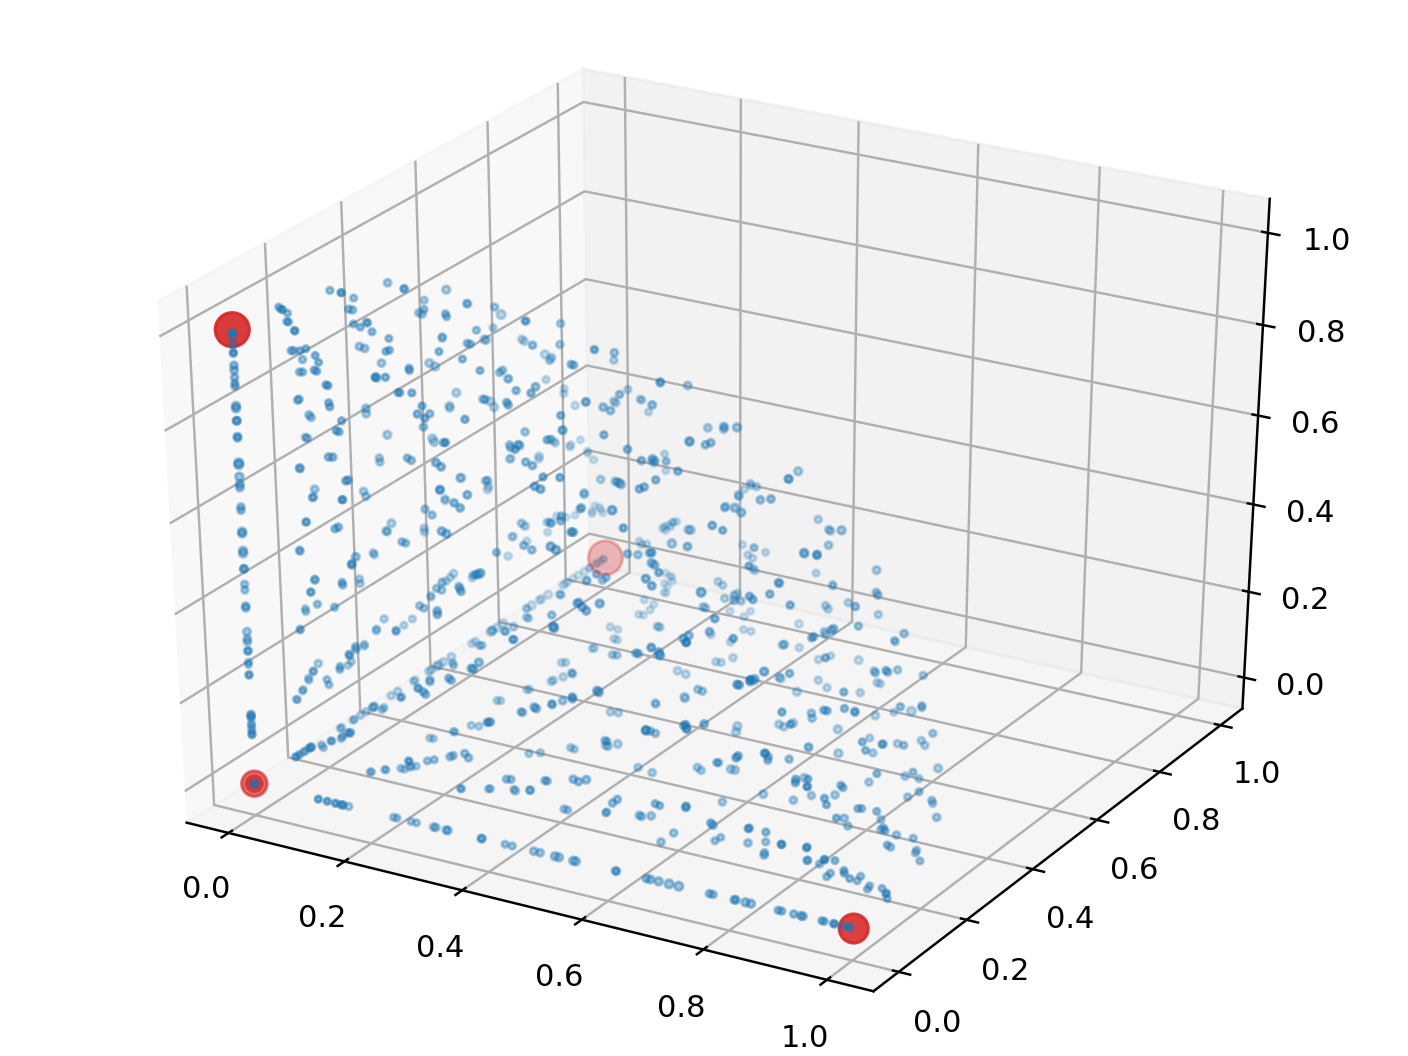

In [5]:
%matplotlib notebook

sys.path.append('../../')
from vis.utils import dm
from vis.plotting.utils import resize_by_tradeoff, default_color, \
                                color_by_cv, enhance_color

eps = dm.epsilons

pf,dim = 'dtlz2-nbi', '5d'

fullpathf = "../../data/{0:s}/{1:s}/dataf.csv".format(pf, dim)
if os.path.exists(fullpathf):
    path, filenamef = os.path.split(fullpathf)
    dirs = path.split('/')
    frontname = dirs[-2]

    F = np.loadtxt(fullpathf, delimiter=',')
    print(fullpathf, F.shape, dirs, frontname)

    Mu,Ik = dm.tradeoff(F, epsilon=eps[dim], penalize_extremes=False)
    mupathf = os.path.join(path, "mu.csv")
    np.savetxt(mupathf, Mu, delimiter=',', fmt="%1.4e")
    muidxpathf = os.path.join(path, "muid.csv")
    np.savetxt(muidxpathf, Ik, delimiter=',', fmt="%d")

    # default color array
    C = default_color(F.shape[0], alpha=0.5)

    # change the size w.r.t. Mu, the values are 
    # too big for smaller size plots, so we make 
    # them half.
    S = resize_by_tradeoff(Mu, k=Ik)

    # load CV if exists, use it for coloring
    cvpathf = os.path.join(path, "datacv.csv")
    if os.path.exists(cvpathf):
        CV = np.loadtxt(cvpathf, delimiter=',')
        C = color_by_cv(CV)

    # enhance the knees with red
    C = enhance_color(C, k=Ik)

    # plot
    ax = Axes3D(plt.figure())
    ax.scatter(F[:,0], F[:,1], F[:,2], c=C, s=S)
    
    plt.show()
else:
    print("Error: {:s} not found.".format(fullpathf))